In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import seaborn as sns

from ISLP.models import ModelSpec as MS
import statsmodels.api as sm


from analysing import AnalysisContainer, AnalysingResults

from tendo_calculations import read_tendo_file
import trimps

from sklearn.preprocessing import scale


df = read_tendo_file('tendo.csv')

df = df.drop(df.columns[:3], axis=1)
df = df[df['rep']<13]


diff_types_training = set(df['training'])
pps = set(df['pp'])


df = trimps.total_work_done(df, return_trimp=False)
test = df.groupby(['rep', 'set', 'training']).mean().reset_index()

#sns.pairplot(test, hue='training')
#test.to_csv('test.csv')


test


,rep,set,training,displacement,time,velocity,pp,delta_v,delta_time,acc,work_done,force,power
0,1,1,LE_HYP_5x12,180.000000,0.324120,0.640073,1.000000,0.010700,0.016229,0.617643,0.287803,625.658562,403.569891
1,1,1,LE_HYP_8x12,164.146341,0.378869,0.488063,2.804878,0.008659,0.001154,0.447061,0.283095,615.423689,297.412585
2,1,1,LE_MAX,140.348837,0.456363,0.351721,2.953488,0.008063,0.004649,0.287524,0.278692,605.851414,211.817259
3,1,1,LP_HYP_5x12,206.144578,0.611134,0.204040,2.566265,0.002839,0.004747,0.109685,0.273783,595.181092,121.197389
4,1,2,LE_HYP_5x12,185.000000,0.336556,0.659184,1.000000,0.010387,-0.002400,0.599783,0.287310,624.587006,404.766762
...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,12,5,LE_HYP_8x12,151.045752,0.345545,0.469835,2.875817,0.009810,-0.001047,0.476248,0.283900,617.174909,286.552101
237,12,5,LP_HYP_5x12,173.623188,0.660878,0.187403,2.594203,0.003596,0.007449,0.143830,0.274726,597.229821,111.916522
238,12,6,LE_HYP_8x12,154.140127,0.439559,0.413924,2.872611,0.008746,0.002575,0.373861,0.281075,611.031631,251.090417
239,12,7,LE_HYP_8x12,150.082645,0.431899,0.421313,2.454545,0.009279,0.003339,0.405113,0.281937,612.906775,256.036521


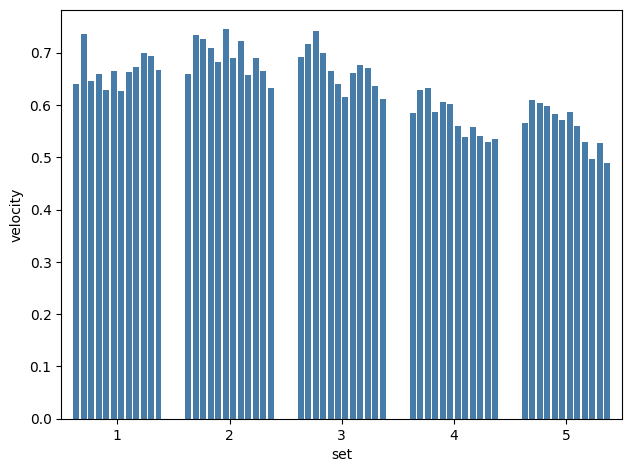

In [2]:

#mooie barcharts for Ian
df_to_plot = test[test['training'] == 'LE_HYP_5x12']
palette = sns.color_palette("Set1")[1]

sns.barplot(data=df_to_plot, x='set', y='velocity', hue='rep', dodge=True, gap=0.2, palette=[palette]*len(df_to_plot['rep'].unique()))
plt.legend().remove()
plt.tight_layout(pad=1.0)
plt.show()

#sns.catplot(data=df_to_plot, x='set', y='velocity', hue='rep', kind='bar')



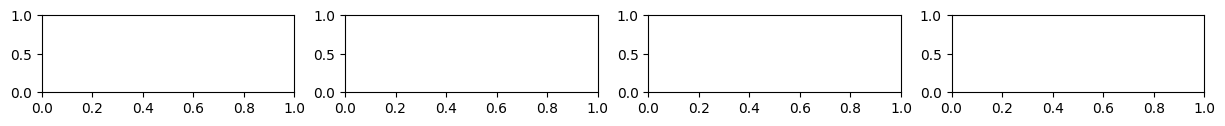

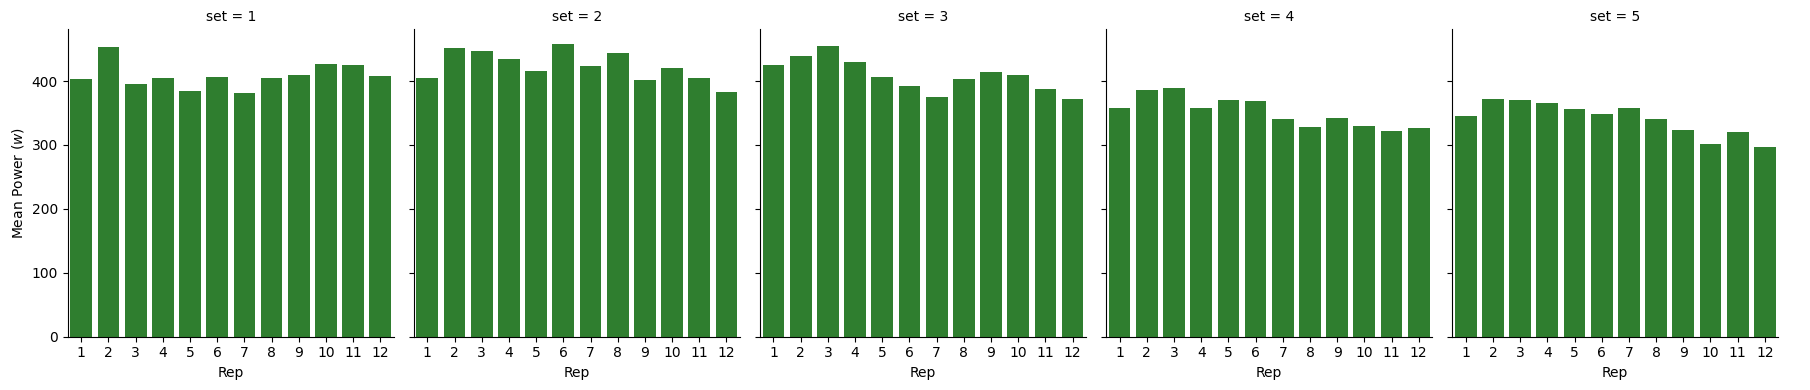

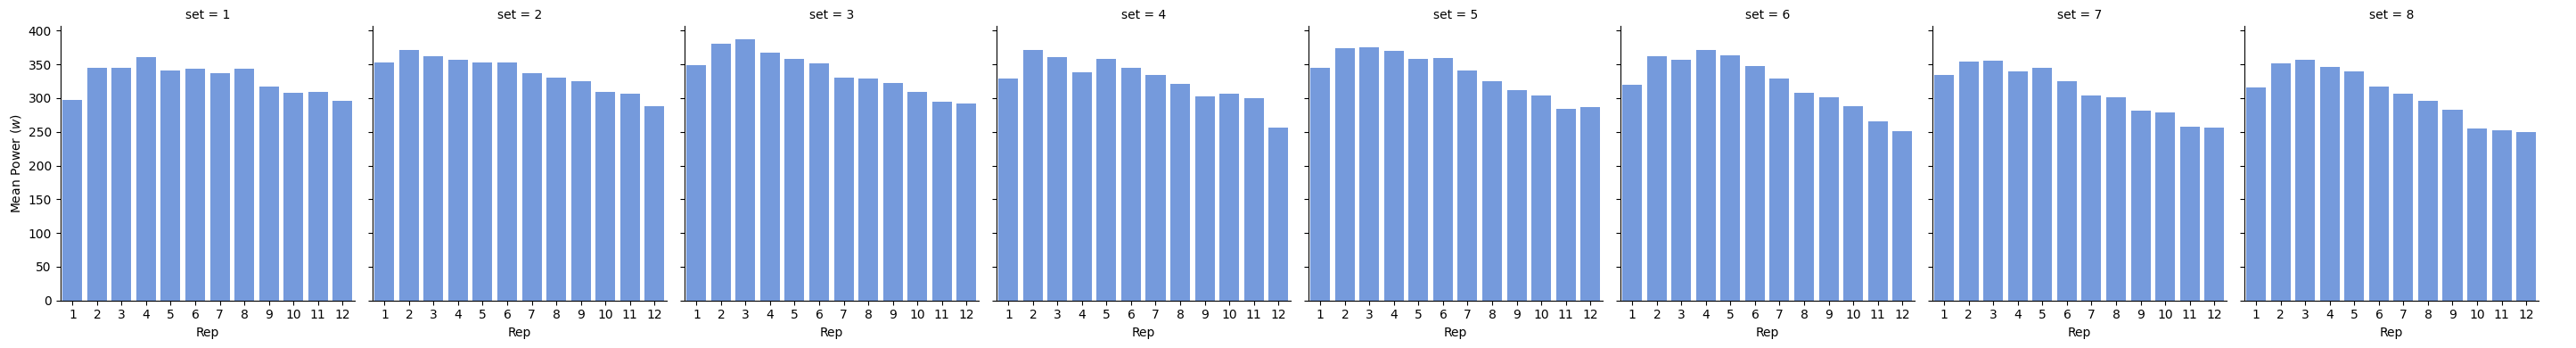

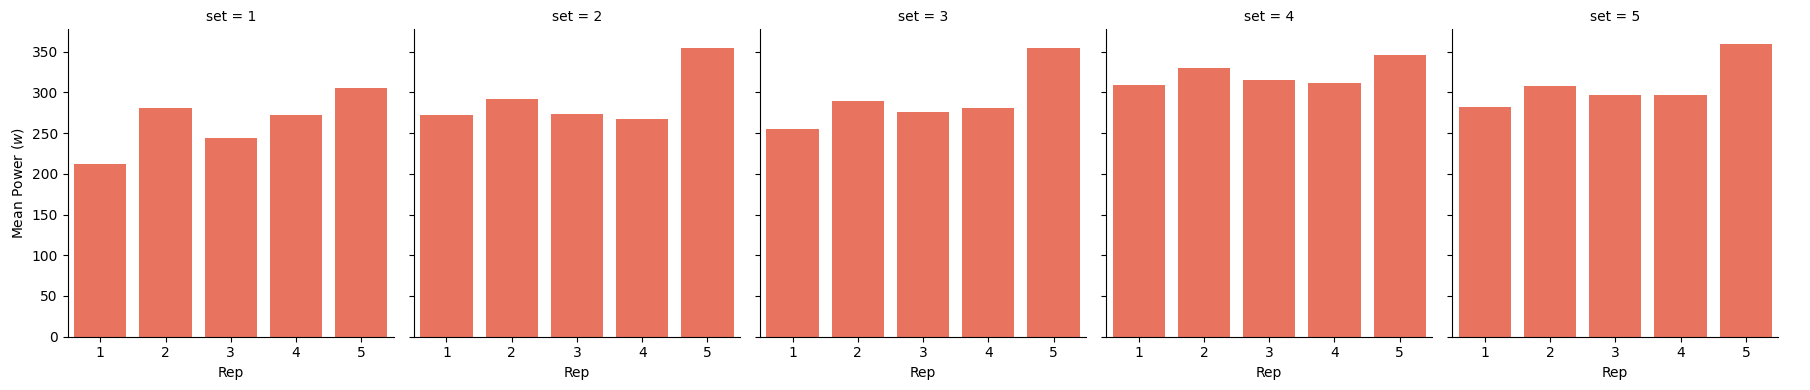

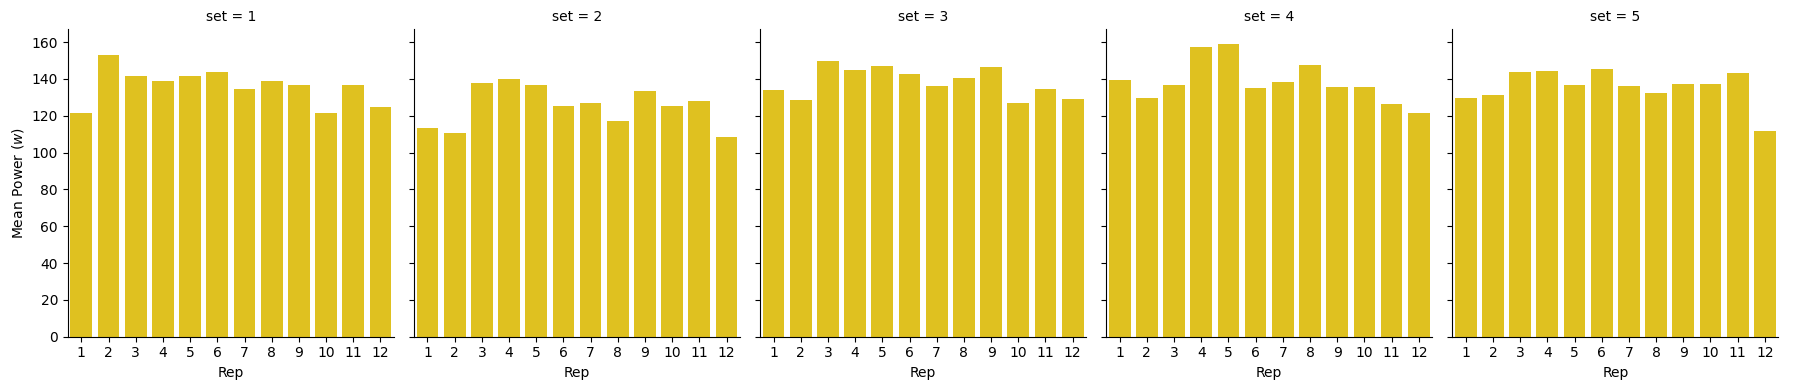

In [3]:
fig, axs = plt.subplots(1, 4, figsize=(15, 1))
color_training = {
    'LE_HYP_5x12':'forestgreen',
    'LE_HYP_8x12': 'cornflowerblue',
    'LE_MAX': 'tomato',
    'LP_HYP_5x12' : 'gold'
}


for i, training in enumerate(diff_types_training):
    df_to_plot = test[test['training'] == training]
   
    # Create the catplot
    g = sns.catplot(
        data=df_to_plot, kind="bar",
        x="rep", y="power", col="set",
        height=4, aspect=.9,
        sharey=True, alpha=1,
        color=color_training[training]
    )

    g.set_axis_labels("Rep", "Mean Power $(w)$")


    # Show the plot

    plt.show()

C:\Users\Simon\AppData\Local\Temp\ipykernel_22848\4266081931.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(
C:\Users\Simon\AppData\Local\Temp\ipykernel_22848\4266081931.py:12: UserWarning: 
The palette list has fewer values (4) than needed (12) and will cycle, which may produce an uninterpretable plot.
  g = sns.catplot(


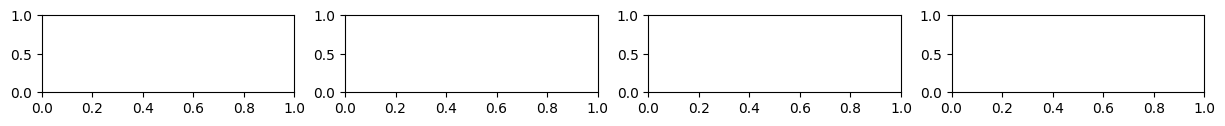

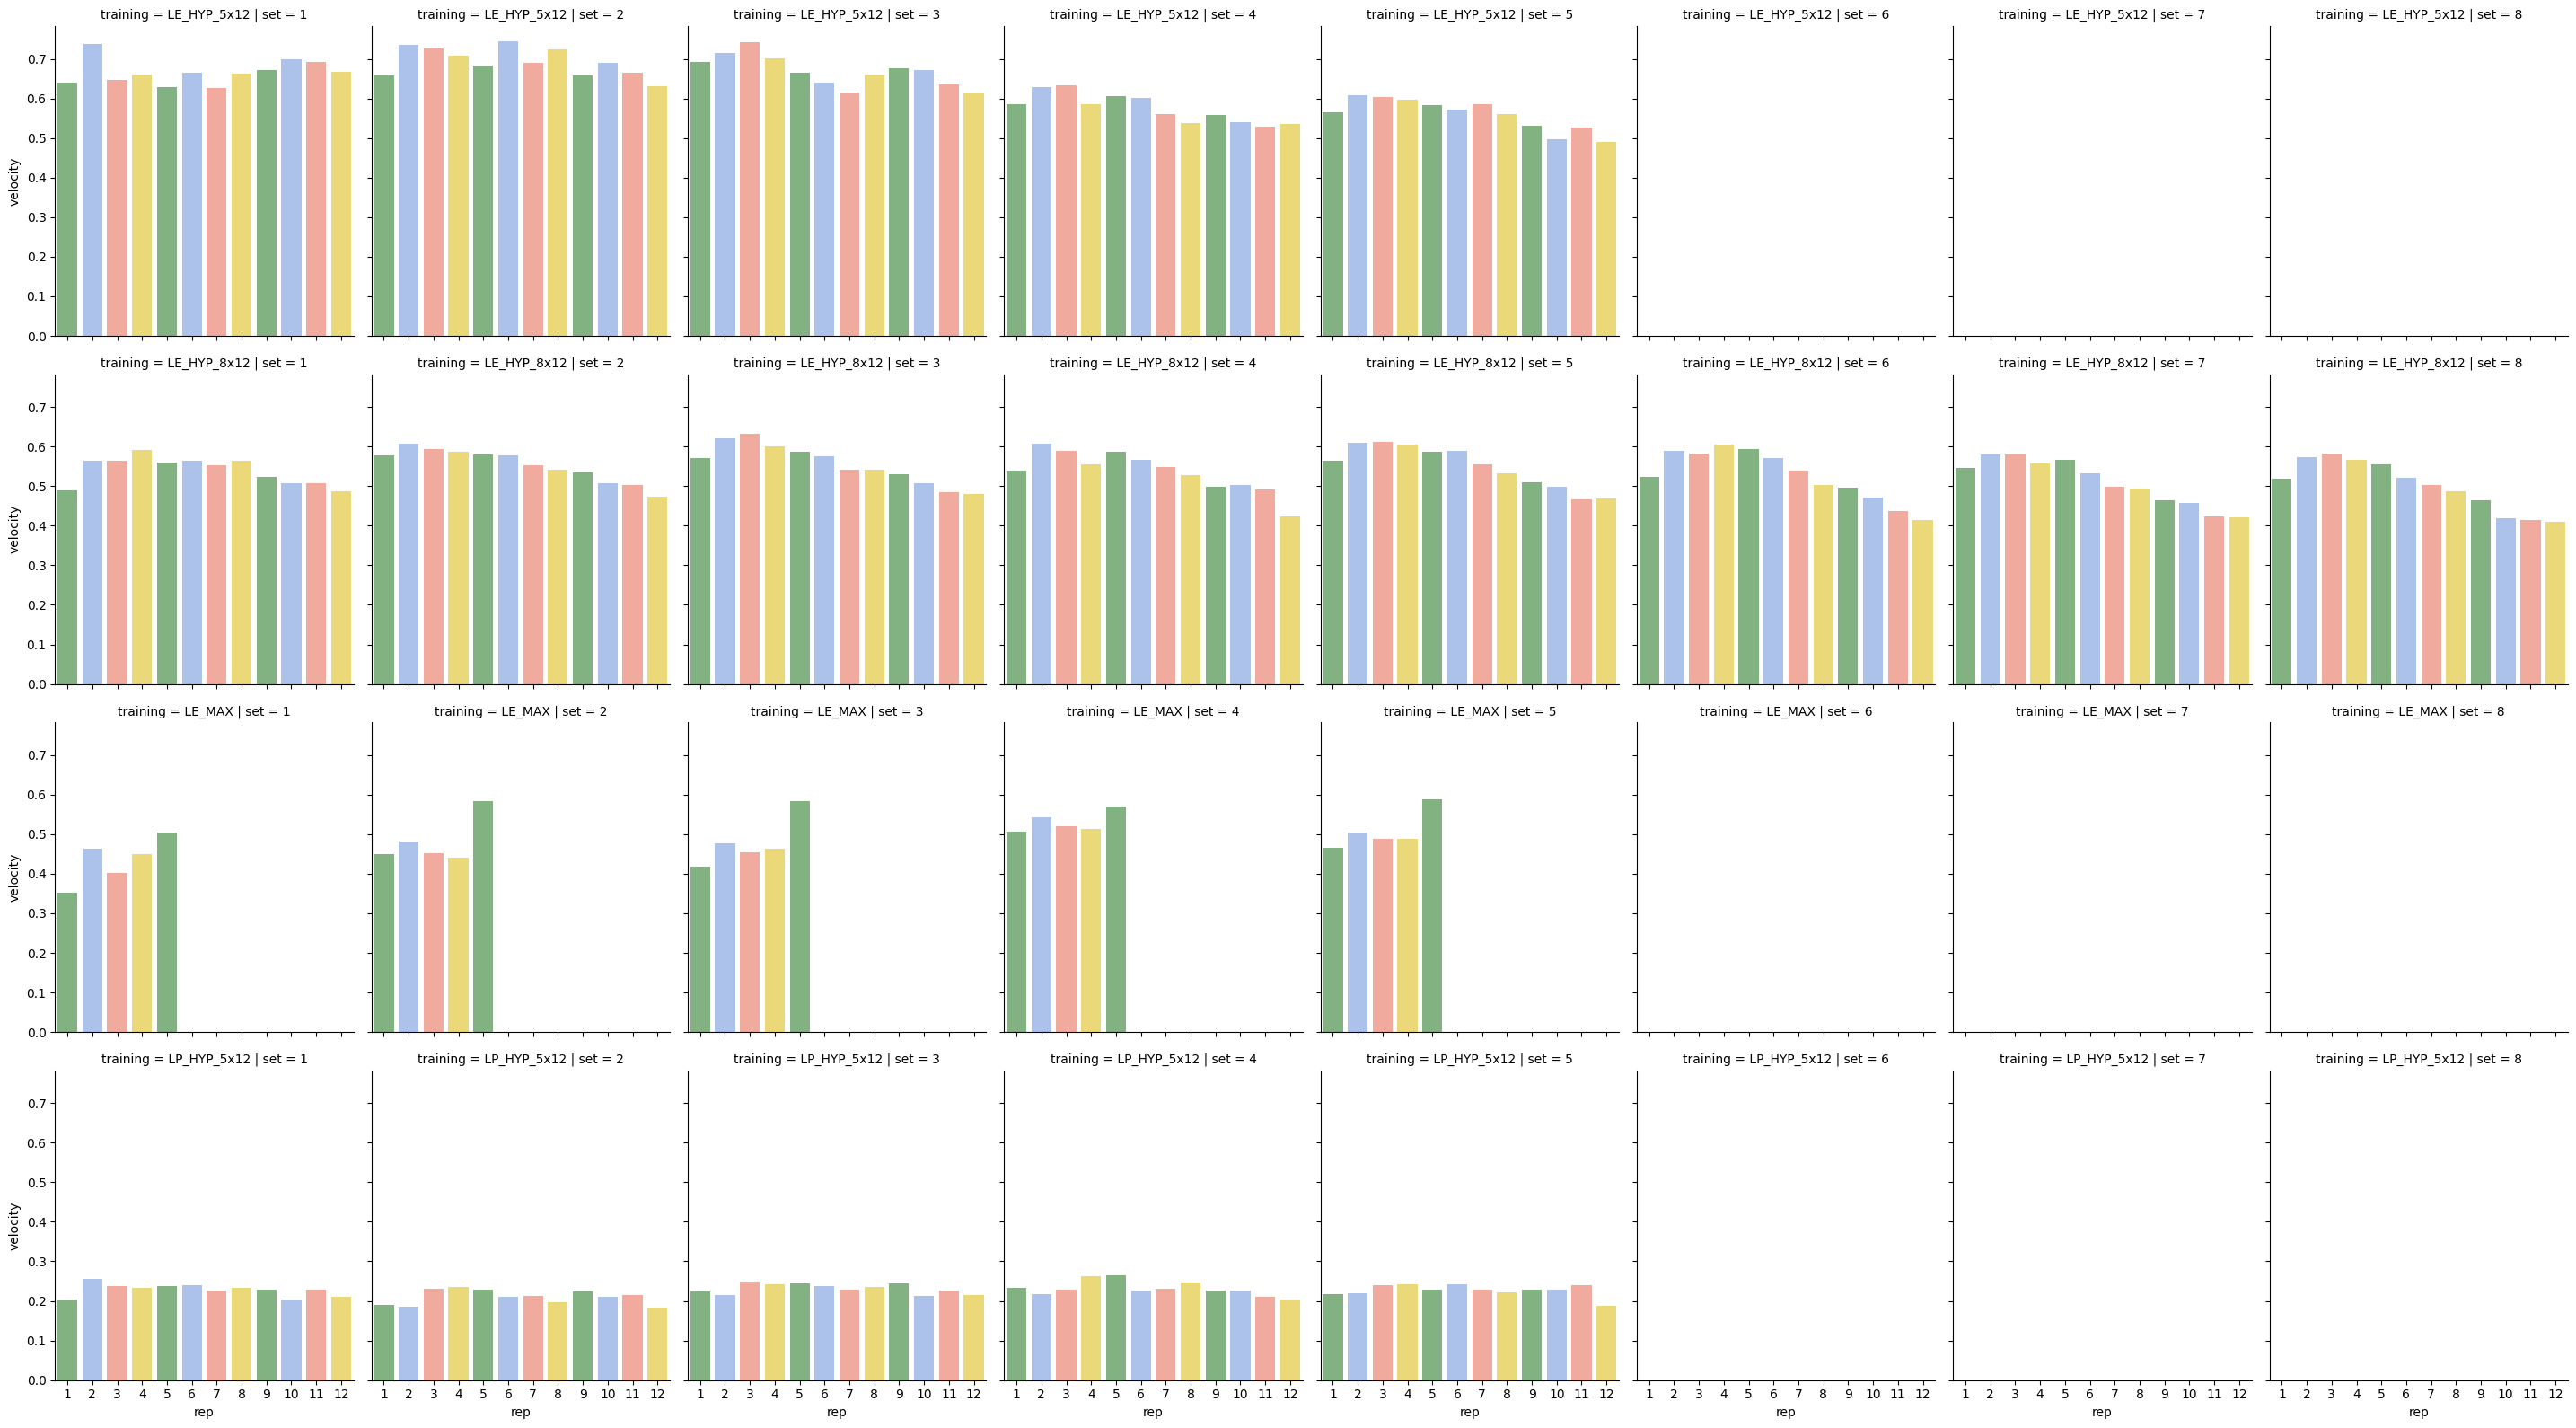

In [4]:
fig, axs = plt.subplots(1, 4, figsize=(15, 1))
color_training = {
    'LE_HYP_5x12':'forestgreen',
    'LE_HYP_8x12': 'cornflowerblue',
    'LE_MAX': 'tomato',
    'LP_HYP_5x12' : 'gold'
}



   
g = sns.catplot(
    data=test, kind="bar",
    x="rep", y="velocity", col="set", row='training',
    height=4, aspect=.9,
    sharey=True, alpha=0.6,
    palette=[color_training[training] for training in test['training'].unique()],
    )



plt.show()


In [5]:


predictors = ['velocity', 'displacement', 'force', 'power']
container = AnalysisContainer()

for predictor in predictors: 
    #fig, axs = plt.subplots(4, 8, figsize=(15, 15))
    #plt.subplots_adjust(wspace=0.5, hspace=0.5)
    for i, training in enumerate(diff_types_training):
        results_avg = AnalysingResults(f'avg_{predictor}_{training}')
        results_max = AnalysingResults(f'max_{predictor}_{training}')
        
        training_filter = (df['training'] == training)
        t_sets = set(df[training_filter]['set'])
        filtered_df = df[training_filter]
        
        for j, t_set in enumerate(t_sets):
            df_to_process = filtered_df[filtered_df['set'] == t_set]
            grouped = df_to_process.groupby(['rep', 'pp'])
            avg = grouped.mean(numeric_only=True).reset_index()
            mx = grouped.max().reset_index()
            
            #ax = axs[i, j]
            
            for pp in set(avg['pp']):
                df_pp_avg = avg[avg['pp']==pp]
                df_pp_max = mx[mx['pp']==pp]
                
                results_max.update(pp, training, t_set, f'max_{predictor}' ,df_pp_max, predictor, plot=False) #, ax=ax, title=f'{training}_{t_set}')
                results_avg.update(pp, training, t_set, f'avg_{predictor}', df_pp_avg, predictor, plot=False)
                
    
        container.update([results_max, results_avg])
         
    #plt.show()
                

output1 = container.df_with_diffrent_columns
output2 = container.df_with_type_column


output1.head(10)


,training,pp,set,B0_max_velocity,B0_std_max_velocity,B1_max_velocity,B1_std_max_velocity,R2_max_velocity,B0_avg_velocity,B0_std_avg_velocity,...,B0_max_power,B0_std_max_power,B1_max_power,B1_std_max_power,R2_max_power,B0_avg_power,B0_std_avg_power,B1_avg_power,B1_std_avg_power,R2_avg_power
0,LE_HYP_5x12,1,1,0.910894,0.026574,0.001480,0.003611,0.016533,0.657108,0.020061,...,609.673481,23.431779,0.036789,3.183752,0.000013,406.602458,12.767733,0.266063,1.734793,0.002347
1,LE_HYP_5x12,1,2,1.001161,0.025557,-0.006954,0.003473,0.286250,0.724078,0.019947,...,684.078781,21.446990,-6.757880,2.914072,0.349720,445.786595,12.685682,-3.316116,1.723645,0.270147
2,LE_HYP_5x12,1,3,0.993115,0.024812,-0.011390,0.003371,0.533008,0.719936,0.017798,...,673.503338,19.599789,-9.738485,2.663087,0.572146,442.243464,11.054545,-5.106142,1.502017,0.536108
3,LE_HYP_5x12,1,4,0.993338,0.025643,-0.012866,0.003484,0.576913,0.707603,0.017333,...,673.501117,21.763677,-11.452903,2.957101,0.600004,432.963969,11.081750,-4.820403,1.505713,0.506149
4,LE_HYP_5x12,1,5,1.036406,0.028755,-0.012030,0.003907,0.486683,0.752672,0.022883,...,702.046248,23.262713,-10.166133,3.160780,0.508474,461.576910,14.625072,-4.981388,1.987156,0.385901
5,LE_HYP_5x12,3,5,0.722136,0.034894,-0.012963,0.004741,0.427782,0.541129,0.025555,...,456.659080,24.915933,-8.976356,3.385409,0.412814,330.946608,15.781364,-6.481236,2.144265,0.477426
6,LE_HYP_5x12,4,4,0.738395,0.015187,-0.017065,0.002064,0.872426,0.531880,0.011179,...,486.085837,12.185070,-13.048525,1.655625,0.861333,327.324731,7.096361,-7.487141,0.964206,0.857746
7,LE_HYP_5x12,4,5,0.735138,0.010893,-0.019243,0.001480,0.944143,0.533696,0.010439,...,480.808922,7.930612,-14.473746,1.077558,0.947484,327.700601,6.675102,-8.793907,0.906968,0.903857
8,LE_HYP_8x12,1,1,1.076718,0.013074,-0.016218,0.001776,0.892885,0.772467,0.012431,...,759.637506,11.279666,-15.078376,1.532605,0.906362,476.008072,7.896514,-6.976218,1.072925,0.808710
9,LE_HYP_8x12,1,2,1.089180,0.013713,-0.017460,0.001863,0.897767,0.778843,0.011764,...,770.653627,12.435652,-16.170780,1.689672,0.901567,479.325165,7.744875,-7.349904,1.052321,0.829882


In [6]:
#df_list = list()
#for training in diff_types_training:
#    for pp in pps:
#        df = output1[(output1['training'] == training) & (output1['pp']==pp)]
#        df = df[df['set'] == df['set'].max()]
#        df_list.append(df)
# 
#df = pd.concat(df_list)
#df = df[[column for column in df.columns if column.startswith('B1_a') or column.startswith('B1_m') or column == 'training' or column =='set' or column == 'pp']]

#df.to_csv('test.csv')


In [7]:
#output2 = output2[output2['']]

avg_tabel = output1.groupby(['training','set']).mean().reset_index()

avg_tabel.head(10)

#max_tabel = output_max.groupby(['training','set']).mean().reset_index()


,training,set,pp,B0_max_velocity,B0_std_max_velocity,B1_max_velocity,B1_std_max_velocity,R2_max_velocity,B0_avg_velocity,B0_std_avg_velocity,...,B0_max_power,B0_std_max_power,B1_max_power,B1_std_max_power,R2_max_power,B0_avg_power,B0_std_avg_power,B1_avg_power,B1_std_avg_power,R2_avg_power
0,LE_HYP_5x12,1,1.000000,0.910894,0.026574,0.001480,0.003611,0.016533,0.657108,0.020061,...,609.673481,23.431779,0.036789,3.183752,0.000013,406.602458,12.767733,0.266063,1.734793,0.002347
1,LE_HYP_5x12,2,1.000000,1.001161,0.025557,-0.006954,0.003473,0.286250,0.724078,0.019947,...,684.078781,21.446990,-6.757880,2.914072,0.349720,445.786595,12.685682,-3.316116,1.723645,0.270147
2,LE_HYP_5x12,3,1.000000,0.993115,0.024812,-0.011390,0.003371,0.533008,0.719936,0.017798,...,673.503338,19.599789,-9.738485,2.663087,0.572146,442.243464,11.054545,-5.106142,1.502017,0.536108
3,LE_HYP_5x12,4,2.500000,0.865867,0.020415,-0.014965,0.002774,0.724670,0.619742,0.014256,...,579.793477,16.974374,-12.250714,2.306363,0.730669,380.144350,9.089055,-6.153772,1.234959,0.681947
4,LE_HYP_5x12,5,2.666667,0.831227,0.024848,-0.014746,0.003376,0.619536,0.609166,0.019625,...,546.504750,18.703086,-11.205412,2.541249,0.622924,373.408039,12.360513,-6.752177,1.679463,0.589061
5,LE_HYP_8x12,1,3.000000,0.743864,0.033853,-0.004501,0.004600,0.540028,0.545634,0.025689,...,482.821489,23.432983,-4.118299,3.183915,0.545995,333.346247,16.055769,-1.676035,2.181549,0.532526
6,LE_HYP_8x12,2,3.000000,0.830397,0.022062,-0.014148,0.002998,0.728302,0.610593,0.017358,...,542.229728,16.112232,-10.502483,2.189221,0.734209,373.653729,10.843399,-6.198933,1.473328,0.704617
7,LE_HYP_8x12,3,3.000000,0.855850,0.027348,-0.017062,0.003716,0.641375,0.634736,0.020397,...,557.956734,22.238760,-11.648974,3.021652,0.578300,388.909599,12.902925,-8.068482,1.753162,0.644000
8,LE_HYP_8x12,4,3.000000,0.826041,0.036299,-0.017480,0.004932,0.572134,0.608815,0.028011,...,537.135919,25.532935,-12.408268,3.469243,0.582755,372.515765,17.583516,-7.840509,2.389129,0.540862
9,LE_HYP_8x12,5,3.000000,0.843645,0.029525,-0.017607,0.004012,0.568415,0.624923,0.023935,...,551.416140,21.498109,-12.633307,2.921018,0.564683,383.607728,15.175540,-8.162796,2.061950,0.540832


B1_std_max_velocity


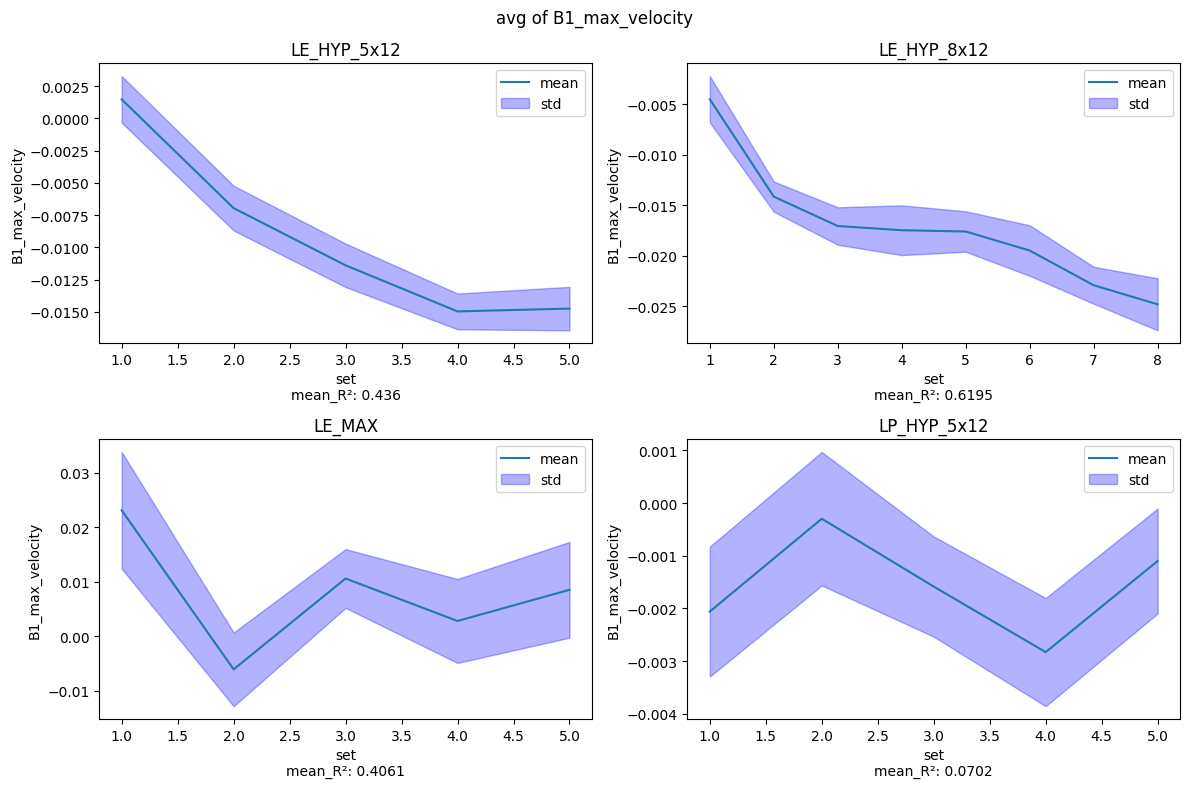

In [8]:
df_to_use = avg_tabel
parameter_to_use = 'B1_max_velocity'
parameter_std = parameter_to_use.split('_')[0] + '_std_' + '_'.join(parameter_to_use.split('_')[1:])
print(parameter_std)

# Create a figure with four subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Flatten the axes array for easier iteration
axes = axes.flatten()

for i, (type, group_data) in enumerate(df_to_use.groupby('training')):
    sns.lineplot(data=group_data, x='set', y=parameter_to_use, label='mean', ax=axes[i])
    
    lower_bound = group_data[parameter_to_use] - group_data[parameter_std] / 2
    upper_bound = group_data[parameter_to_use] + group_data[parameter_std] / 2
    
    # Fill between the interval bounds
    axes[i].fill_between(group_data['set'], lower_bound, upper_bound, color='blue', alpha=0.3, label='std')
    axes[i].text(0.5, -0.2, f"mean_R²: {round(group_data[f'R2{parameter_to_use[2:]}'].mean(),4)}", transform=axes[i].transAxes, fontsize=10, ha='center')
    
    axes[i].set_title(type)
    axes[i].legend()

fig.suptitle(f'avg of {parameter_to_use}')
# Adjust layout to prevent overlap
plt.tight_layout()

plt.show()

In [9]:
df['training'].unique()

array(['LE_HYP_5x12', 'LE_HYP_8x12', 'LP_HYP_5x12', 'LE_MAX'],
      dtype=object)

In [10]:
parameter = 'velocity'
max_p = True
set_df = df[df['training']=='LE_HYP_8x12']




if max_p == True:
    max_velocity = set_df.groupby(['set', 'rep', 'pp']).max().reset_index()
    
else:
    max_velocity = set_df.groupby(['set', 'rep', 'pp']).mean().reset_index()


#for pp in set(max_velocity['pp']):
#max_velocity = max_velocity[max_velocity['pp']==pp]
#X = np.array(max_velocity['set'], dtype=int)
#Y = np.array(max_velocity['rep'], dtype=int)
#Z = np.array(max_velocity[parameter])



    # Create a meshgrid for X and Y
    #X_grid, Y_grid = np.meshgrid(X, Y)
    #
    #
    #
    ## Initialize Z values with zeros
    #Z = np.zeros_like(X_grid, dtype=float)
    #
    ## Assign velocity values to Z based on corresponding 'set' and 'rep'
    #for j in range(len(Y)):
    #    for i in range(len(X)):
    #        set_value = X_grid[j][i]
    #        rep_value = Y_grid[j][i]
    #        velocity_value = max_velocity[(max_velocity['set'] == set_value) & (max_velocity['rep'] == rep_value)]['velocity'].values
    #        if velocity_value: 
    #            Z[j][i] = velocity_value[0]






#fig = plt.figure()
#ax = fig.add_subplot(111)#, projection='3d')
#surf = ax.tripcolor(X, Y, Z, cmap='viridis', vmin=0.30, vmax=0.85)
#
#ax.set_xlabel('Set')
#ax.set_ylabel('Rep')
##ax.set_zlabel(f'max {parameter}')
#
#
#fig.colorbar(surf, shrink=0.5, aspect=5)
#plt.show()
#heatmap_data = max_velocity.pivot(index='rep', columns='set', values='velocity')
#sns.heatmap(heatmap_data, cmap='viridis', vmax=0.85, vmin=0.3, annot=True)

#sns.pairplot(max_velocity, hue='pp')
#df_to_scatter = max_velocity[max_velocity['rep'] == 12]
#fig, axs = plt.subplots(5, 1, figsize=(8, 15))
#for i, pp in enumerate(pps):
#    sns.scatterplot(data =df_to_scatter[df_to_scatter['pp'] == pp], x='velocity', y='force', ax = axs[i], hue='set')
   

In [11]:
%matplotlib qt
#df_mulitple_reg = max_velocity[max_velocity['pp']!=4]
df_mulitple_reg = max_velocity
dummies = pd.get_dummies(df_mulitple_reg['pp'])
X = pd.concat([dummies, df_mulitple_reg[['set', 'rep']]], axis=1)
X = sm.add_constant(X)

print(X)

#predictors = ['power', 'velocity', 'force', 'displacement']
#
#for i, set in enumerate(df_mulitple_reg['set'].unique()):
#    plt.figure()
#    sns.lmplot(data=df_mulitple_reg[df_mulitple_reg['set'] == set],
#                    y='force', x='rep', hue='pp')
#    plt.show()
    
    
#plt.legend(title='pp', bbox_to_anchor=(1.05, 1), loc='upper left')

#plt.show()


for p in predictors:
    df_mulitple_reg[p] = scale(df_mulitple_reg[p])
    y = df_mulitple_reg[p] 
    model = sm.OLS(y,X)
    result = model.fit()
    print(result.summary())



     const  1  2  3  4  5  set  rep
0      1.0  1  0  0  0  0    1    1
1      1.0  0  1  0  0  0    1    1
2      1.0  0  0  1  0  0    1    1
3      1.0  0  0  0  1  0    1    1
4      1.0  0  0  0  0  1    1    1
..     ... .. .. .. .. ..  ...  ...
472    1.0  0  0  0  1  0    8   11
473    1.0  1  0  0  0  0    8   12
474    1.0  0  1  0  0  0    8   12
475    1.0  0  0  1  0  0    8   12
476    1.0  0  0  0  1  0    8   12

[477 rows x 8 columns]
                            OLS Regression Results                            
Dep. Variable:               velocity   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.778
Method:                 Least Squares   F-statistic:                     278.9
Date:                Fri, 17 May 2024   Prob (F-statistic):          2.26e-151
Time:                        22:02:40   Log-Likelihood:                -314.90
No. Observations:                 477   AIC:                          

In [12]:
df2 = trimps.total_work_done(set_df, return_trimp=False)
df2.head(5)

c:\Users\Simon\Documents\Ugent\Master\master proef\python\final_analysis\trimps.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['work_done'] = mass* (group['acc']+9.81) * (group['displacement'].max()/1000)
c:\Users\Simon\Documents\Ugent\Master\master proef\python\final_analysis\trimps.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['force'] =  mass* (group['acc']+9.81)
c:\Users\Simon\Documents\Ugent\Master\master proef\python\final_analysis\trimps.py:96: SettingWithCopyWarning: 
A valu

,displacement,time,velocity,rep,set,pp,training,delta_v,delta_time,acc,work_done,force,power
3594,0,0.000000,0.0000,1,1,1,LE_HYP_8x12,0.0000,-0.686088,-0.000000,0.258984,588.600000,0.000000
3595,10,0.048576,0.0090,1,1,1,LE_HYP_8x12,0.0090,0.048576,0.185277,0.263875,599.716601,5.397449
3596,20,0.082808,0.1756,1,1,1,LE_HYP_8x12,0.1666,0.034232,4.866791,0.387467,880.607478,154.634673
3597,30,0.107096,0.3021,1,1,1,LE_HYP_8x12,0.1265,0.024288,5.208333,0.396484,901.100000,272.222310
3598,40,0.127640,0.3989,1,1,1,LE_HYP_8x12,0.0968,0.020544,4.711838,0.383377,871.310280,347.565671


In [13]:
max_velocity = df2.groupby(['set', 'rep'])['work_done'].sum().reset_index()
max_velocity2 = df2.groupby(['set', 'rep'])['force', 'velocity', 'power'].max().reset_index()


df_for_linear_regression = max_velocity.merge(max_velocity2, on=['set', 'rep'])

df_for_linear_regression = df_for_linear_regression[df_for_linear_regression['power']>0]

X = MS(['force', 'velocity']).fit_transform(df_for_linear_regression)

y = df_for_linear_regression['power']

model = sm.OLS(y,X)
result = model.fit()



sns.pairplot(df_for_linear_regression, hue='training')
result.summary()

C:\Users\Simon\AppData\Local\Temp\ipykernel_22848\2148836535.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  max_velocity2 = df2.groupby(['set', 'rep'])['force', 'velocity', 'power'].max().reset_index()


KeyError: 'training'

In [ ]:


# Generate some sample data
np.random.seed(0)
n = 100
categories = np.random.choice(['A', 'B', 'C'], size=n)
x = np.random.randn(n)
y = 2 * x + np.random.randn(n)  # Assuming linear relationship

# Create a DataFrame
data = pd.DataFrame({'x': x, 'y': y, 'category': categories})

# Create dummy variables for the categorical variable
data = pd.get_dummies(data, columns=['category'], drop_first=True)

# Add a constant for the intercept
data = sm.add_constant(data)

print(data)
# Fit the linear regression model
model = sm.OLS(data['y'], data[['const', 'x', 'category_B', 'category_C']])
results = model.fit()

# Print the summary of the regression results
print(results.summary())


    const         x         y  category_B  category_C
0     1.0 -0.686589 -1.520984           0           0
1     1.0  0.014873  1.713574           1           0
2     1.0 -0.375666  0.220500           0           0
3     1.0 -0.038224  1.531227           1           0
4     1.0  0.367974  0.478821           1           0
..    ...       ...       ...         ...         ...
95    1.0 -0.033236 -0.481700           0           0
96    1.0  0.065641 -0.507804           0           1
97    1.0  0.265786  3.029339           0           0
98    1.0  1.151842 -0.701444           1           0
99    1.0  0.138043 -0.597911           0           1

[100 rows x 5 columns]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     105.1
Date:       